In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import tensorflow as tf
import keras
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l1,l2
from sklearn.utils import class_weight

In [4]:
data_set_path = '/content/drive/MyDrive/Dataset/cpvr_student/Dataset'

In [5]:
SEED = 42
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16

In [6]:
class_name = os.listdir(data_set_path)
class_name.sort()
class_numbers = len(class_name)
class_name

['ASHHAB',
 'Abir',
 'Afif',
 'Alvi',
 'Apurba',
 'Arshad',
 'Ashiq',
 'Avizit',
 'Dristi',
 'Farhan',
 'GM ABUBAKAR SIDDIQ',
 'Hasib',
 'Hasnatur',
 'Ishmam',
 'Jahin',
 'Khushbu',
 'Kowshik',
 'MAYSHA',
 'MRIDUL',
 'Maishara',
 'Mehrab',
 'Nishat',
 'Prachurjo',
 'Pranto',
 'Rafsan',
 'Ramisa',
 'Rassel',
 'Ridoy',
 'Rizon',
 'Rokon',
 'Rono',
 'SHOHIDUL',
 'SHUVO',
 'SUN',
 'Sadi',
 'Saif',
 'Sakib',
 'Sanim',
 'Sayem',
 'Shaila',
 'Shaivik',
 'Shakibul',
 'Shatabdi',
 'ShuvoSaha',
 'Siam',
 'Sintheia',
 'Sumaiya',
 'Tahsin',
 'Tahsin Kabir',
 'Taj',
 'Talha',
 'Zarin',
 'ajmain']

In [7]:
# import shutil

# for class_name in os.listdir(data_set_path):
#     class_dir = os.path.join(data_set_path, class_name)
#     if os.path.isdir(class_dir):
#         num_images = len(os.listdir(class_dir))
#         if num_images < 2:
#             print(f"Deleting '{class_name}' directory with {num_images} images.")
#             shutil.rmtree(class_dir)

## Visualizing the dataset consistencey

422


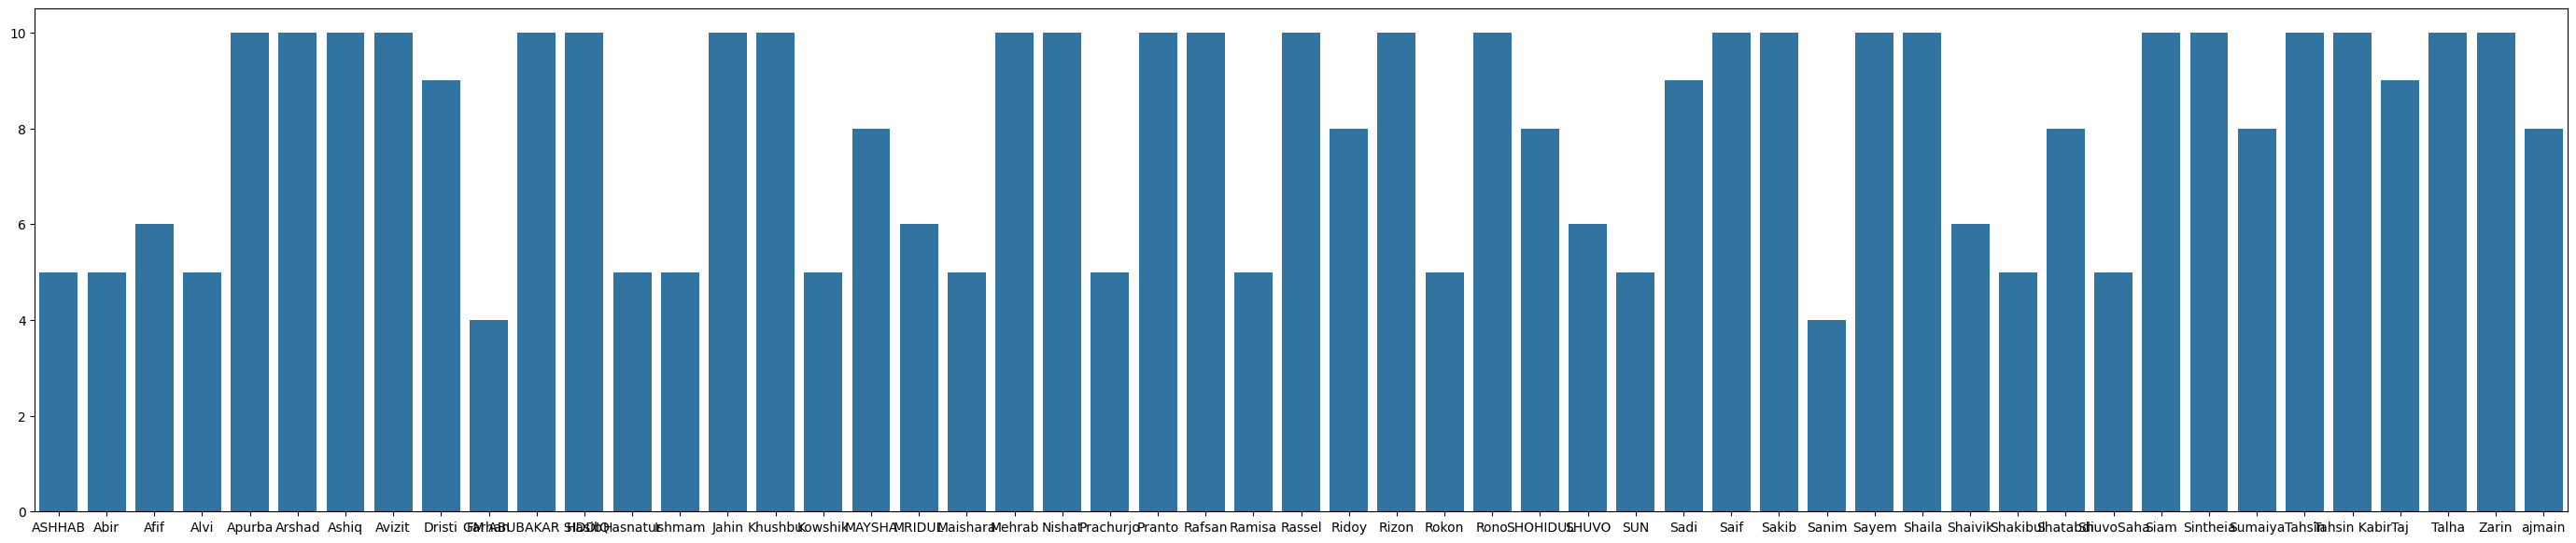

In [8]:
per_class_images = []
TRAIN_EXAMPLES = 0
for n in class_name:
  images = glob.glob(str(data_set_path +'/'+ n +'/*'))
  per_class_images.append(len(images))
  TRAIN_EXAMPLES +=len(images)

plt.figure(figsize=(35,7))
sns.barplot(x=class_name, y=per_class_images)
print(TRAIN_EXAMPLES)

## Preprocessing the dataset

In [9]:
train_gen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range=[0.8, 1.2],
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest',
    brightness_range=[0.8, 1.2],
    preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input,
    # preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
)

In [10]:
train_batch = train_gen.flow_from_directory(
  directory =  data_set_path,
  target_size = (IMG_SIZE,IMG_SIZE),
  batch_size = TRAIN_BATCH_SIZE,
  class_mode = 'sparse',
  seed = SEED,
  subset='training'
)

val_batch = train_gen.flow_from_directory(
  directory=data_set_path,
  target_size=(IMG_SIZE, IMG_SIZE),
  batch_size=VAL_BATCH_SIZE,
  class_mode='sparse',
  seed=SEED,
  subset='validation'
)

Found 335 images belonging to 53 classes.
Found 71 images belonging to 53 classes.


In [11]:
# Calculate class weights
y_train = train_batch.classes  # Get the training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [12]:
img, labels = next(train_batch)

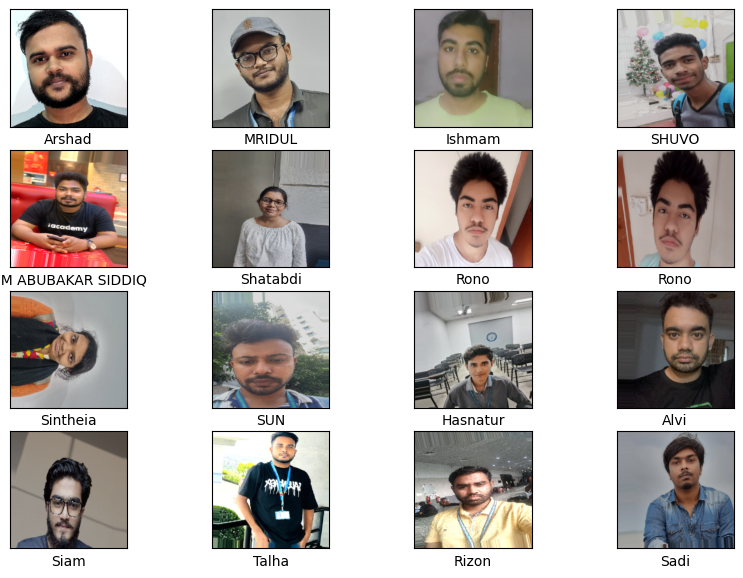

In [13]:
plt.figure(figsize=(10,7))
for i in range(TRAIN_BATCH_SIZE):
  plt.subplot(4,TRAIN_BATCH_SIZE//4,i+1)
  plt.imshow(img[i].astype('uint8'))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(class_name[int(labels[i])])
plt.show()

## Transfer Learning

In [14]:
inp_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV3Large(include_top=False, input_shape=inp_shape, weights='imagenet')
#base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=inp_shape, weights='imagenet')

base_model.trainable = False
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

In [15]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

output = tf.keras.layers.Dense(class_numbers, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 53)                  │           6,837 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,537,333 (13.49 MB)

 Trainable params: 540,981 (2.06 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [16]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), #clipnorm=0.8
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    min_lr=0.000001,
    verbose=1
)

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
initial_epochs = 40
h = model.fit(
    train_batch,
    epochs=initial_epochs,
    #steps_per_epoch= train_batch.samples // TRAIN_BATCH_SIZE,
    validation_data=val_batch,
    #validation_steps= val_batch.samples // VAL_BATCH_SIZE,
    #class_weight=class_weight_dict,
    callbacks=[early_stopping,lr_scheduler],
    verbose=2
)

Learning rate:  0.001
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 - 137s - 7s/step - accuracy: 0.0119 - loss: 6.4535 - val_accuracy: 0.1127 - val_loss: 5.6524 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 2/40
21/21 - 59s - 3s/step - accuracy: 0.0537 - loss: 5.2497 - val_accuracy: 0.1127 - val_loss: 4.7738 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 3/40
21/21 - 82s - 4s/step - accuracy: 0.0716 - loss: 4.5438 - val_accuracy: 0.0986 - val_loss: 4.2897 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 4/40
21/21 - 46s - 2s/step - accuracy: 0.0776 - loss: 4.1615 - val_accuracy: 0.1127 - val_loss: 3.8926 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 5/40
21/21 - 81s - 4s/step - accuracy: 0.1045 - loss: 3.8379 - val_accuracy: 0.1972 - val_loss: 3.5197 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 6/40
21/21 - 45s - 2s/step - accuracy: 0.1701 - loss: 3.5660 - val_accuracy: 0.2254 - val_loss: 3.3728 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 7/40
21/21 - 53s - 3s/step - accuracy: 0.1642 - loss: 3.3855 - val_accurac

In [ ]:
val_loss, val_accuracy = model.evaluate(val_batch)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

In [ ]:
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [ ]:
h.history

In [ ]:
#model.save('/content/drive/MyDrive/Models/mobilenetv3_8.keras')